# Figure 9: Classification Accuracy Comparison

This notebook generates figures comparing classification accuracy between UMAP-based simulation origin probabilities (SOPs) and autoencoder predictions across UMAP space.

**Two 6-panel figures are generated:**
1. **Unweighted Classification Comparison**
2. **Weighted Classification Comparison**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
from matplotlib.colors import Normalize
import sys
import pickle
import cmasher as cmr
from scipy.interpolate import RegularGridInterpolator

# Add src to path
sys.path.append('../src')

from utils.analysis import (sim_name, colors, times, boxing, 
                           P_x_s, P_s_x)
from utils.data_processing import load_autoencoder_data
from utils.plotting import (plot_points, plot_averages, 
                           draw_battleship_grid)

# LaTeX font setup
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

%matplotlib inline

## Load Data

In [2]:
# Load processed simulation data
with open('../data/sim_data_processed.pkl', 'rb') as f:
    sim_data = pickle.load(f)

# Load UMAP embeddings
combined_labels = np.load('../data/combined_labels.npy')
embedding = np.load('../data/umap_embedding.npy')
combined_sfh = np.load('../data/combined_sfh.npy')

# Reconstruct UMAP embeddings by simulation
for i, sim in enumerate(sim_name):
    if sim_data[sim] is not None:
        sim_mask = combined_labels == i
        sim_data[sim]['umap'] = embedding[sim_mask]

print("Loaded UMAP data by simulation:")
for sim in sim_name:
    if sim_data[sim] is not None:
        print(f"{sim:>15s}: {sim_data[sim]['umap'].shape[0]:>8,d} galaxies")

Loaded UMAP data by simulation:
          EAGLE:    7,445 galaxies
      Illustris:   19,354 galaxies
   IllustrisTNG:   12,220 galaxies
         Mufasa:    1,900 galaxies
          Simba:    1,982 galaxies
         SC-SAM:   12,821 galaxies
UniverseMachine:    7,361 galaxies


In [3]:
# Load autoencoder predictions
ae_data = load_autoencoder_data(sim_data)

print("Loaded autoencoder data.")

Loaded predictions_sfh.npy: shape (63083, 139)
Loaded predictions_sfh_w.npy: shape (63083, 139)
Loaded predictions_sfr.npy: shape (63083, 2)
Loaded predictions_sfr_w.npy: shape (63083, 2)
Loaded predictions_sim.npy: shape (63083, 7)
Loaded predictions_sim_w.npy: shape (63083, 7)
Reordering predictions from sim_name_z to sim_name order...
Reordered predictions_sfh: shape (63083, 139)
Reordered predictions_sfh_w: shape (63083, 139)
Reordered predictions_sfr: shape (63083, 2)
Reordered predictions_sfr_w: shape (63083, 2)
Reordered predictions_sim: shape (63083, 7), columns reordered to sim_name
Reordered predictions_sim_w: shape (63083, 7), columns reordered to sim_name
Split EAGLE: 7445 galaxies
Split Illustris: 19354 galaxies
Split IllustrisTNG: 12220 galaxies
Split Mufasa: 1900 galaxies
Split Simba: 1982 galaxies
Split SC-SAM: 12821 galaxies
Split UniverseMachine: 7361 galaxies
Loaded autoencoder data.


In [4]:
# Create battleship grid structure
result = np.column_stack((embedding, combined_labels))
umaps = boxing(result[:,0], result[:,1], result)

print("Created battleship grid (10x10):")
non_empty_cells = sum(1 for i in range(10) for j in range(10) if umaps[i,j].shape[0] > 0)
print(f"  Non-empty grid cells: {non_empty_cells}/100")

# Calculate average SFH percentiles per grid cell
avg_sfh = boxing(x=embedding[:,0], y=embedding[:,1], z=combined_sfh, q=[16,50,84])

print(f"\nCalculated average SFHs per cell: shape {avg_sfh.shape}")

Created battleship grid (10x10):
  Non-empty grid cells: 69/100

Calculated average SFHs per cell: shape (10, 10, 3, 136)


## Calculate UMAP-based Simulation Origin Probabilities

In [5]:
# Create high-resolution grid for SOP calculation
xx, yy = np.mgrid[0:10:100j, 0:10:100j]
pos = np.vstack([xx.ravel(), yy.ravel()])

In [6]:
print("Calculating UMAP-based simulation origin probabilities for Method 1 (Galaxy count weighting)...")

# Method 1: Galaxy count weighted approach (bias=True, normint=False)
p_s_x = P_s_x(x=pos, sim_name=sim_name, sim_data=sim_data, umaps=umaps, 
              normint=False, bias=True, mask=False)

for sim in sim_name:
    if sim_data[sim] is not None:
        max_prob = np.nanmax(p_s_x[sim])
        print(f"{sim:>15s}: Max probability = {max_prob:.4f}")

# Create 2D interpolators for p_s_x over the grid for each simulation
p_s_x_interp = {}
for sim in sim_name:
    if sim_data[sim] is not None:
        # Reshape p_s_x[sim] to 2D grid (100x100)
        p_grid = p_s_x[sim].reshape(100, 100)
        # Create interpolator
        p_s_x_interp[sim] = RegularGridInterpolator((xx[:, 0], yy[0, :]), p_grid, 
                                                   bounds_error=False, fill_value=np.nan)
        
# Evaluate over individual galaxy positions
p_s_x_eval = {}
for sim in sim_name:
    if sim_data[sim] is not None:
        p_s_x_eval[sim] = p_s_x_interp[sim](embedding)

# Normalize over each galaxy across simulations
for i in range(len(embedding)):
    total = sum(p_s_x_eval[sim][i] for sim in sim_name if sim_data[sim] is not None)
    if total > 0:
        for sim in sim_name:
            if sim_data[sim] is not None:
                p_s_x_eval[sim][i] /= total

# Get predicted simulation (highest probability)
predicted_sim = [np.argmax([p_s_x_eval[sim][i] for sim in sim_name]) for i in range(len(embedding))]

# Calculate probability of correct class
correct_class_prob = [p_s_x_eval[sim][i] for i, sim in enumerate(sim_name[combined_labels])]

# Calculate accuracy (correct prediction)
accuracy = (predicted_sim == combined_labels.astype(int)).astype(float)

print(f"\nCalculated probabilities and accuracy for {len(embedding):,} galaxies.")
print(f"Overall accuracy (Method 1): {np.mean(accuracy)*100:.2f}%")

Calculating UMAP-based simulation origin probabilities for Method 1 (Galaxy count weighting)...


c:\Users\joshs\Dropbox\GitHub\savelli-kustec-gal-sfh\notebooks\../src\utils\analysis.py:312: RuntimeWarning: invalid value encountered in subtract
  log_p_s_x_sim = log_p_x_s[sim] + log_p_s[sim] - log_p_x


          EAGLE: Max probability = 0.3880
      Illustris: Max probability = 0.8358
   IllustrisTNG: Max probability = 0.5500
         Mufasa: Max probability = 0.3840
          Simba: Max probability = 0.4560
         SC-SAM: Max probability = 0.9566
UniverseMachine: Max probability = 0.7109

Calculated probabilities and accuracy for 63,083 galaxies.
Overall accuracy (Method 1): 49.36%


In [7]:
print("Calculating UMAP-based simulation origin probabilities for Method 2 (equally weighted)...")

# Method 2: Equal weighting approach (bias=False, normint=False)
p_s_x2 = P_s_x(x=pos, sim_name=sim_name, sim_data=sim_data, umaps=umaps, 
               normint=False, bias=False, mask=False)

for sim in sim_name:
    if sim_data[sim] is not None:
        max_prob = np.nanmax(p_s_x2[sim])
        print(f"{sim:>15s}: Max probability = {max_prob:.4f}")

from scipy.interpolate import RegularGridInterpolator

# Create 2D interpolators for p_s_x over the grid for each simulation
p_s_x2_interp = {}
for sim in sim_name:
    if sim_data[sim] is not None:
        # Reshape p_s_x[sim] to 2D grid (100x100)
        p_grid = p_s_x2[sim].reshape(100, 100)
        # Create interpolator
        p_s_x2_interp[sim] = RegularGridInterpolator((xx[:, 0], yy[0, :]), p_grid, 
                                                   bounds_error=False, fill_value=np.nan)
        
# Evaluate over individual galaxy positions
p_s_x2_eval = {}
for sim in sim_name:
    if sim_data[sim] is not None:
        p_s_x2_eval[sim] = p_s_x2_interp[sim](embedding)

# Normalize over each galaxy across simulations
for i in range(len(embedding)):
    total = sum(p_s_x2_eval[sim][i] for sim in sim_name if sim_data[sim] is not None)
    if total > 0:
        for sim in sim_name:
            if sim_data[sim] is not None:
                p_s_x2_eval[sim][i] /= total

# Get predicted simulation (highest probability)
predicted_sim2 = [np.argmax([p_s_x2_eval[sim][i] for sim in sim_name]) for i in range(len(embedding))]

# Calculate probability of correct class
correct_class_prob2 = [p_s_x2_eval[sim][i] for i, sim in enumerate(sim_name[combined_labels])]

# Calculate accuracy (correct prediction)
accuracy2 = (predicted_sim2 == combined_labels.astype(int)).astype(float)

print(f"\nCalculated probabilities and accuracy for {len(embedding):,} galaxies.")
print(f"Overall accuracy (Method 2): {np.mean(accuracy2)*100:.2f}%")

Calculating UMAP-based simulation origin probabilities for Method 2 (equally weighted)...
          EAGLE: Max probability = 0.4861
      Illustris: Max probability = 0.7024
   IllustrisTNG: Max probability = 0.4853
         Mufasa: Max probability = 0.6282
          Simba: Max probability = 0.6689
         SC-SAM: Max probability = 0.8865
UniverseMachine: Max probability = 0.4270

Calculated probabilities and accuracy for 63,083 galaxies.
Overall accuracy (Method 2): 44.99%


## Process Autoencoder Predictions

In [8]:
def logit_to_prob(logits):
    """Convert logits to probabilities using softmax."""
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

In [9]:
print("Calculating simulation origin probabilities for Autoencoder predictions (weighted)...")

# Convert autoencoder logits to probabilities
psim_ae_w = logit_to_prob(ae_data['predictions_sim_w'])
psim_ae_w /= psim_ae_w.sum(axis=1, keepdims=True)

# Get predicted simulations
predicted_sim_ae_w = np.argmax(ae_data['predictions_sim_w'], axis=1)
correct_class_prob_ae_w = [psim_ae_w[i, sim] for i, sim in enumerate(combined_labels)]
accuracy_ae_w = (predicted_sim_ae_w == combined_labels.astype(int)).astype(float)

print(f"\nCalculated probabilities and accuracy for {len(embedding):,} galaxies.")
print(f"Overall accuracy (Autoencoder): {np.mean(accuracy_ae_w)*100:.2f}%")

Calculating simulation origin probabilities for Autoencoder predictions (weighted)...

Calculated probabilities and accuracy for 63,083 galaxies.
Overall accuracy (Autoencoder): 91.30%


In [10]:
print("Calculating simulation origin probabilities for Autoencoder predictions (unweighted)...")

# Convert autoencoder logits to probabilities
psim_ae = logit_to_prob(ae_data['predictions_sim'])
psim_ae /= psim_ae.sum(axis=1, keepdims=True)

# Get predicted simulations
predicted_sim_ae = np.argmax(ae_data['predictions_sim'], axis=1)
correct_class_prob_ae = [psim_ae[i, sim] for i, sim in enumerate(combined_labels)]
accuracy_ae = (predicted_sim_ae == combined_labels.astype(int)).astype(float)

print(f"\nCalculated probabilities and accuracy for {len(embedding):,} galaxies.")
print(f"Overall accuracy (Autoencoder): {np.mean(accuracy_ae)*100:.2f}%")

Calculating simulation origin probabilities for Autoencoder predictions (unweighted)...

Calculated probabilities and accuracy for 63,083 galaxies.
Overall accuracy (Autoencoder): 91.37%


## Generate Figures Using draw_grid_D

In [11]:
# Import draw_grid_D for proper figure layout
from utils.plotting import draw_grid_D
import cmasher as cmr

print("Figure generation functions imported")

Figure generation functions imported


In [12]:
# Create accuracy grids for plotting
sop_unw_acc_grid = boxing(x=embedding[:,0], y=embedding[:,1], z=accuracy2, average=True)
sop_w_acc_grid = boxing(x=embedding[:,0], y=embedding[:,1], z=accuracy, average=True)
ae_unw_acc_grid = boxing(x=embedding[:,0], y=embedding[:,1], z=accuracy_ae, average=True)
ae_w_acc_grid = boxing(x=embedding[:,0], y=embedding[:,1], z=accuracy_ae_w, average=True)

c:\Users\joshs\Dropbox\GitHub\savelli-kustec-gal-sfh\notebooks\../src\utils\analysis.py:101: RuntimeWarning: Mean of empty slice
  box = np.nanmean(box, axis=0)


## Generate Figure 1: Unweighted Classification Comparison

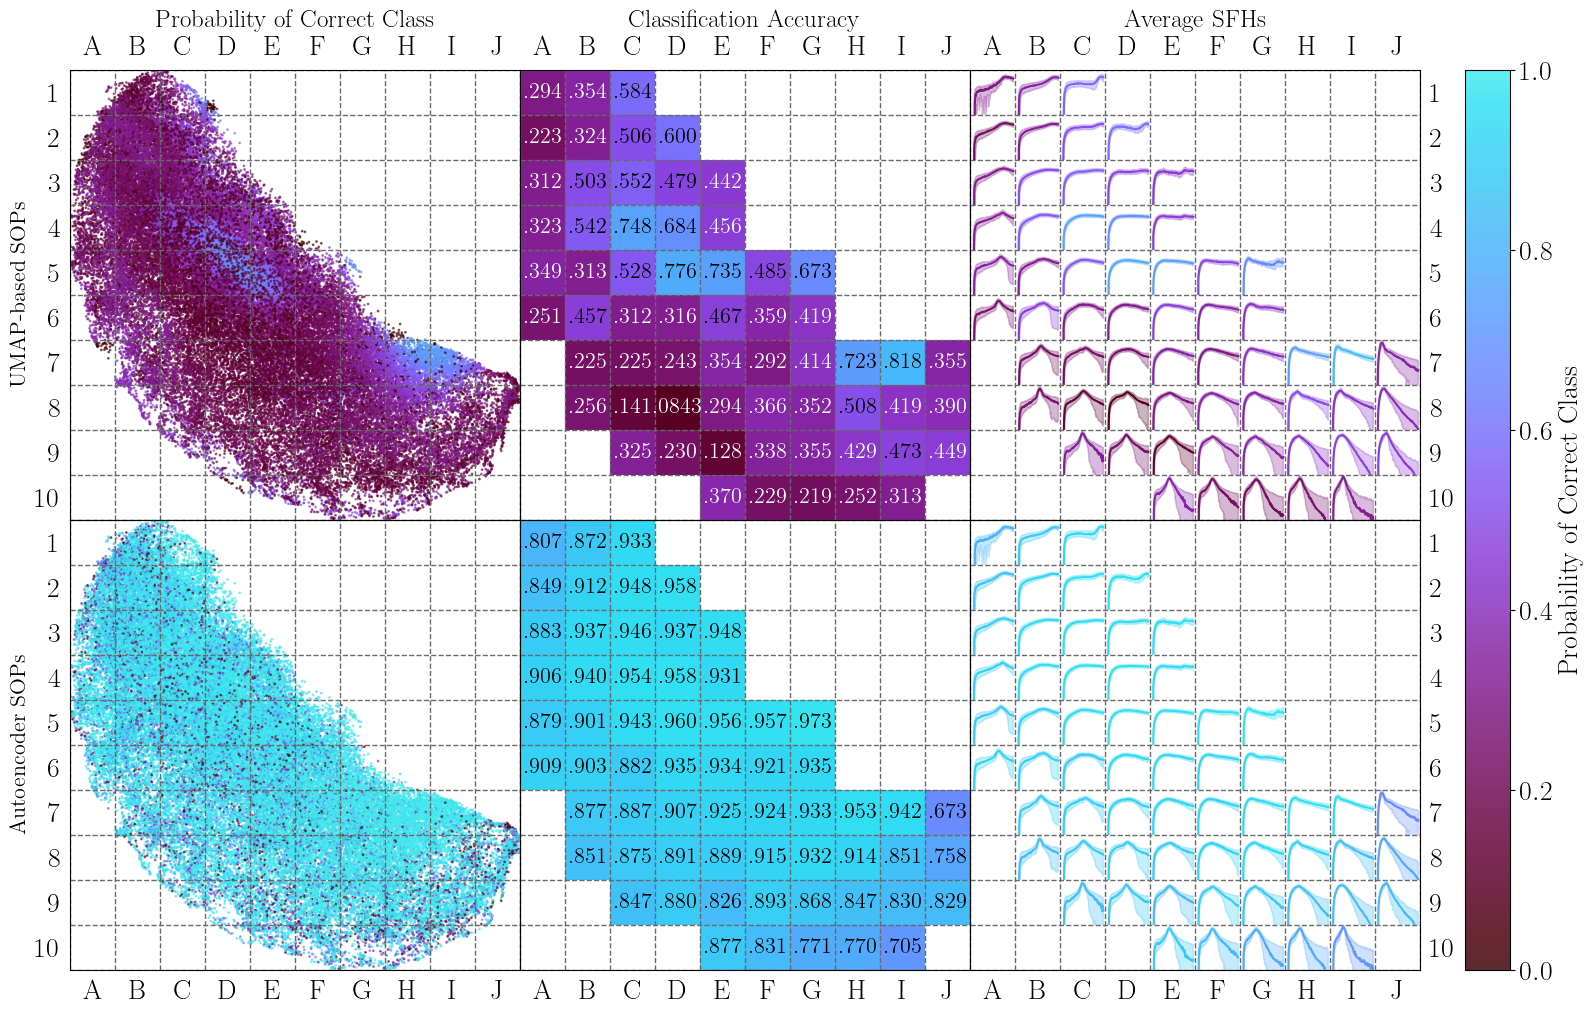

Unweighted classification comparison figure generated!


In [13]:
# Set up colormaps for both rows
cmap = cmr.gem  # Same colormap for both methods

# Create figure using draw_grid_D (2 rows x 3 columns)
fig, ax, norm = draw_grid_D(cmap=cmap, vmin=0, vmax=1, lognorm=False)

# Row 1: UMAP-based SOPs (unweighted)
plot_points(x=embedding[:,0], y=embedding[:,1], z=correct_class_prob2, alpha=0.6, s=1,
           fig=fig, ax=ax[0], cax=ax[-1], cmap=cmap, norm=norm, 
           extend='neither', label='Probability of Correct Class')

plot_averages(sop_unw_acc_grid, avg_sfh, fig, ax[1], ax[2], umaps, cmap, norm, ftype='f')

# Row 2: Autoencoder (unweighted)
plot_points(x=embedding[:,0], y=embedding[:,1], z=correct_class_prob_ae, alpha=0.6, s=1,
           fig=fig, ax=ax[3], cax=ax[-1], cmap=cmap, norm=norm, 
           extend='neither', label='Probability of Correct Class')

plot_averages(ae_unw_acc_grid, avg_sfh, fig, ax[4], ax[5], umaps, cmap, norm, ftype='f')

# Add row labels
ax[0].set_ylabel('UMAP-based SOPs', fontsize=16)
ax[3].set_ylabel('Autoencoder SOPs', fontsize=16)

# Add column titles
ax[0].set_title('Probability of Correct Class', fontsize=18)
ax[1].set_title('Classification Accuracy', fontsize=18)
ax[2].set_title('Average SFHs', fontsize=18)

# Save figure
plt.savefig('../figures/classification_accuracy_unweighted.png', bbox_inches='tight', dpi=300)
plt.savefig('../figures/classification_accuracy_unweighted.pdf', bbox_inches='tight')

plt.show()
print("Unweighted classification comparison figure generated!")

## Generate Figure 2: Weighted Classification Comparison

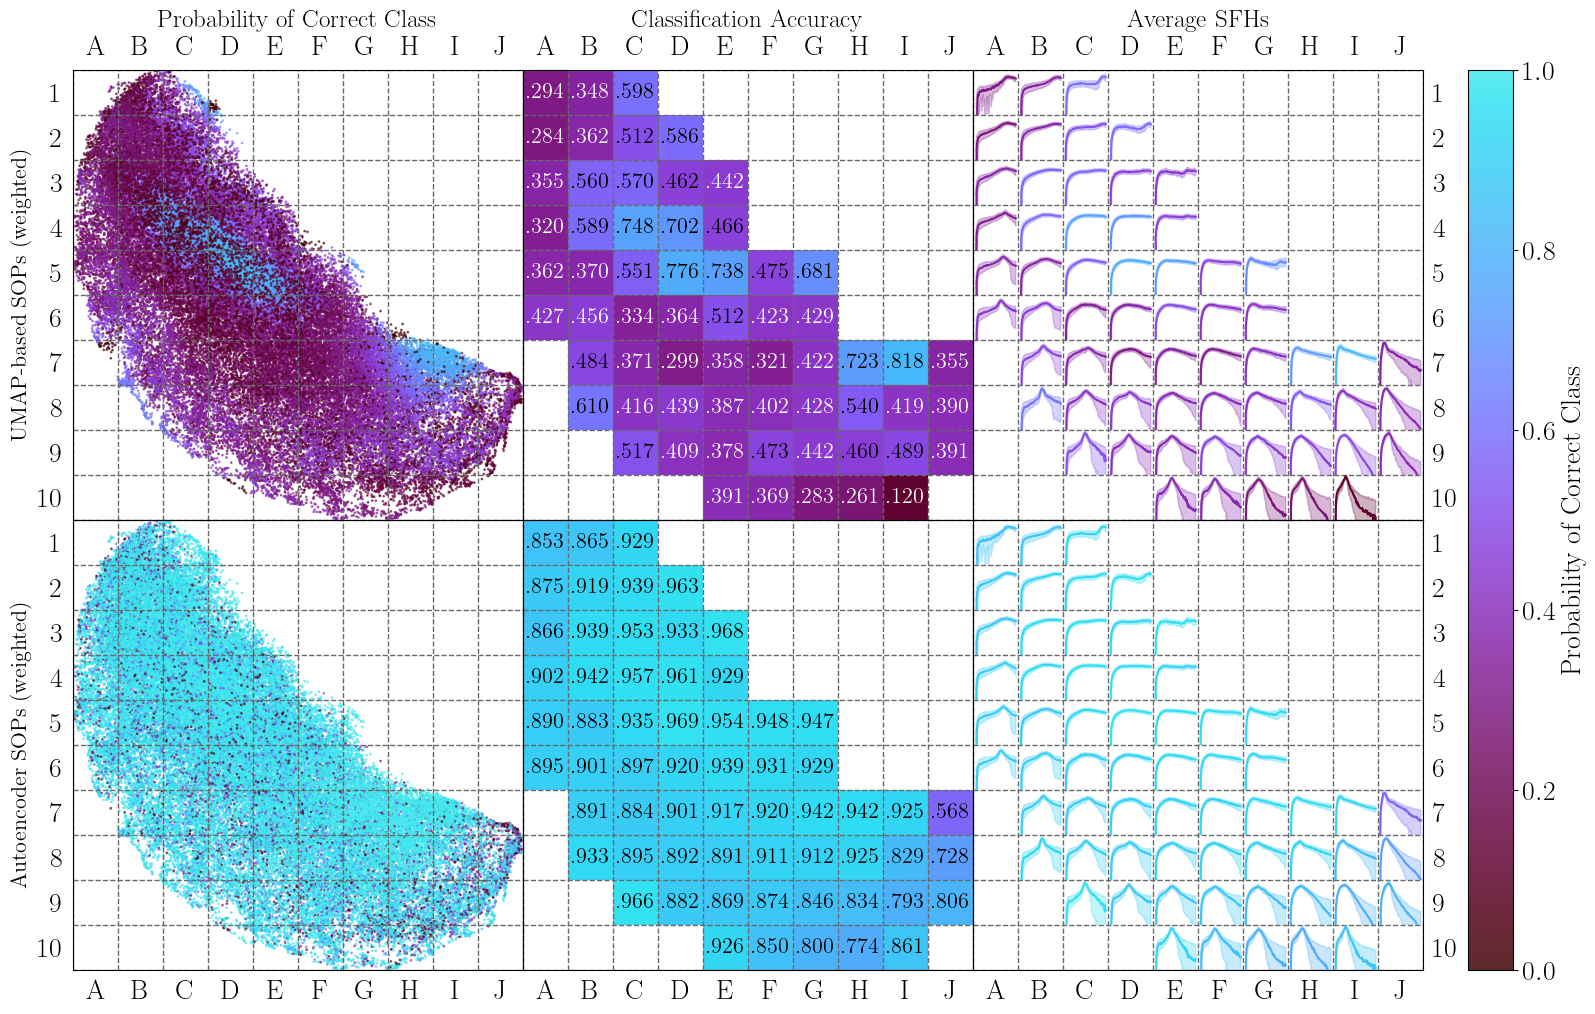

Weighted classification comparison figure generated!


In [14]:
# Use same draw_grid_D signature/format as the unweighted figure (single cmap argument)
fig, ax, norm = draw_grid_D(cmap=cmap, vmin=0, vmax=1, lognorm=False)

# Row 1: UMAP-based SOPs (weighted)
plot_points(x=embedding[:,0], y=embedding[:,1], z=correct_class_prob, alpha=0.6, s=1,
           fig=fig, ax=ax[0], cax=ax[-1], cmap=cmap, norm=norm, 
           extend='neither', label='Probability of Correct Class')

plot_averages(sop_w_acc_grid, avg_sfh, fig, ax[1], ax[2], umaps, cmap, norm, ftype='f')

# Row 2: Autoencoder (weighted)
plot_points(x=embedding[:,0], y=embedding[:,1], z=correct_class_prob_ae_w, alpha=0.6, s=1,
           fig=fig, ax=ax[3], cax=ax[-1], cmap=cmap, norm=norm, 
           extend='neither', label='Probability of Correct Class')

plot_averages(ae_w_acc_grid, avg_sfh, fig, ax[4], ax[5], umaps, cmap, norm, ftype='f')

# Add row labels
ax[0].set_ylabel('UMAP-based SOPs (weighted)', fontsize=16)
ax[3].set_ylabel('Autoencoder SOPs (weighted)', fontsize=16)

# Add column titles
ax[0].set_title('Probability of Correct Class', fontsize=18)
ax[1].set_title('Classification Accuracy', fontsize=18)
ax[2].set_title('Average SFHs', fontsize=18)

# Save figure
plt.savefig('../figures/classification_accuracy_weighted.png', bbox_inches='tight', dpi=300)
plt.savefig('../figures/classification_accuracy_weighted.pdf', bbox_inches='tight')

plt.show()
print("Weighted classification comparison figure generated!")